In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 587, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 587 (delta 7), reused 0 (delta 0), pack-reused 570
Receiving objects: 100% (587/587), 13.21 MiB | 2.06 MiB/s, done.
Resolving deltas: 100% (347/347), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 22.6 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hyperparameters-tuning-better/best_params_knn_item.json
/kaggle/input/hyperparameters-tuning-better/__results__.html
/kaggle/input/hyperparameters-tuning-better/better_tuning.db
/kaggle/input/hyperparameters-tuning-better/submission.csv
/kaggle/input/hyperparameters-tuning-better/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning-better/__output__.json
/kaggle/input/hyperparameters-tuning-better/custom.css
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/rp3-tuning.ipynb
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/README.md
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/run_hyperparame

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2158


In [8]:
config = {
    'tune_parameters_item_knn': False,
    'tune_parameters_user_knn': True,
    'tune_parameters_ials': False,
    'database_path': '/kaggle/working/better_tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/better_tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


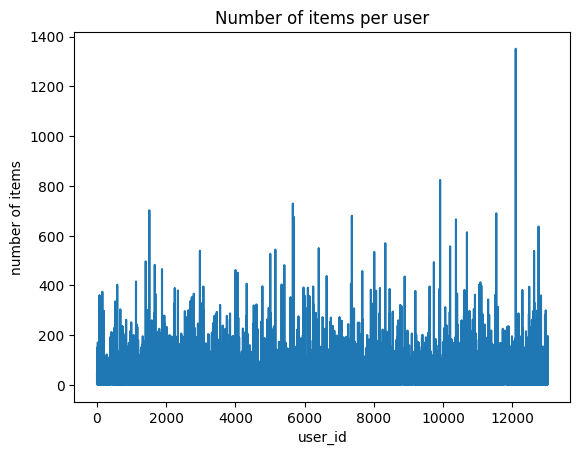

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

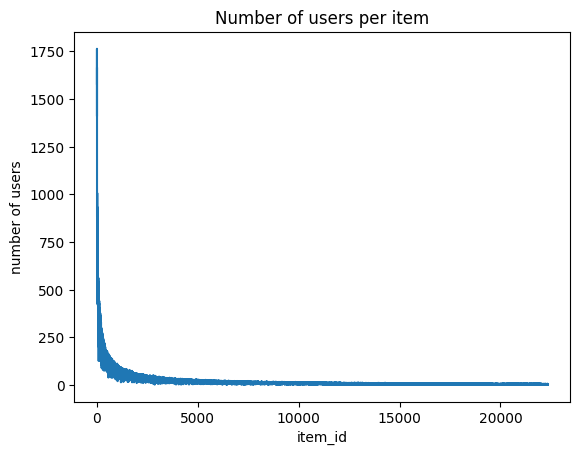

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

# Hyperparameters tuning

In [24]:
import sqlite3

def print_all_rows(table_name, database_path):
    connection = sqlite3.connect(database_path)
    cursor = connection.cursor()

    try:
        cursor.execute(f"SELECT * FROM {table_name};")
        rows = cursor.fetchall()

        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        cursor.close()
        connection.close()

print_all_rows('studies', config['database_path'])

All rows from table 'studies':
(1, 'hyperparameters_tuning_knn_item')


## Item KNN Collaborative Filtering

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

In [25]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_item_knn(URM_train, URM_valid, params):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']


def objective_item_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_item_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
        
    return np.mean(results)

In [26]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=50)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.54 µs


In [27]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [28]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [29]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [30]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [31]:
def evaluate_user_knn(URM_train, URM_valid, params):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']

def objective_user_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_user_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
    return np.mean(results)

In [32]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=100)

[I 2023-11-24 14:10:32,708] A new study created in RDB with name: hyperparameters_tuning_knn_user


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 568 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1151 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 14:13:23,863] Trial 0 finished with value: 0.01201870908663189 and parameters: {'topK': 896, 'shrink': 298, 'similarity': 'tversky', 'tversky_alpha': 0.3568193316613435, 'tversky_beta': 1.7640218716372662}. Best is trial 0 with value: 0.01201870908663189.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1138 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 832 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 14:16:11,167] Trial 1 finished with value: 0.01208175733232402 and parameters: {'topK': 802, 'shrink': 257, 'similarity': 'cosine'}. Best is trial 1 with value: 0.01208175733232402.


MAP is 0.016371097428084735
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 777 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 512 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1458 (11.2%) users with no interacti

[I 2023-11-24 14:18:55,107] Trial 2 finished with value: 0.01407336506802227 and parameters: {'topK': 645, 'shrink': 313, 'similarity': 'dice'}. Best is trial 2 with value: 0.01407336506802227.


MAP is 0.019120506963611488
ItemKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1463 (11.2%) users with no interacti

[I 2023-11-24 14:21:37,757] Trial 3 finished with value: 0.011572527343071225 and parameters: {'topK': 996, 'shrink': 318, 'similarity': 'cosine'}. Best is trial 2 with value: 0.01407336506802227.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 222 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 508 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1126 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1460 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 14:24:22,194] Trial 4 finished with value: 0.012778452418041148 and parameters: {'topK': 919, 'shrink': 151, 'similarity': 'cosine'}. Best is trial 2 with value: 0.01407336506802227.


MAP is 0.017650262501755814
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 220 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-24 14:26:59,304] Trial 5 finished with value: 0.015634901738875696 and parameters: {'topK': 163, 'shrink': 381, 'similarity': 'tversky', 'tversky_alpha': 1.981627156133482, 'tversky_beta': 1.5557079864962517}. Best is trial 5 with value: 0.015634901738875696.


MAP is 0.0154240071937164
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 866 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10.9%) users with no interaction

[I 2023-11-24 14:33:40,451] Trial 6 finished with value: 0.006815897050645517 and parameters: {'topK': 228, 'shrink': 90, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'lin', 'normalize': False}. Best is trial 5 with value: 0.015634901738875696.


ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 14:36:19,906] Trial 7 finished with value: 0.012157045312526777 and parameters: {'topK': 329, 'shrink': 466, 'similarity': 'cosine'}. Best is trial 5 with value: 0.015634901738875696.



ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 565 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 869 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1413 (10.8%) users with no interactions.
ItemKNNCFRecommender: 

[I 2023-11-24 14:38:55,757] Trial 8 finished with value: 0.013028495359167466 and parameters: {'topK': 26, 'shrink': 3, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.7133592508532034}. Best is trial 5 with value: 0.015634901738875696.


MAP is 0.02114745520849846
ItemKNNCFRecommender: URM Detected 510 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 773 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 383 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11.3%) users with no interactio

[I 2023-11-24 14:41:33,217] Trial 9 finished with value: 0.015421001116476785 and parameters: {'topK': 562, 'shrink': 116, 'similarity': 'dice'}. Best is trial 5 with value: 0.015634901738875696.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 861 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 14:44:10,101] Trial 10 finished with value: 0.015559261461455597 and parameters: {'topK': 30, 'shrink': 456, 'similarity': 'tversky', 'tversky_alpha': 1.9614113707679681, 'tversky_beta': 0.7973088499684855}. Best is trial 5 with value: 0.015634901738875696.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 464 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 14:46:45,672] Trial 11 finished with value: 0.015530715465285564 and parameters: {'topK': 88, 'shrink': 462, 'similarity': 'tversky', 'tversky_alpha': 1.9561306576541992, 'tversky_beta': 0.7620171665602209}. Best is trial 5 with value: 0.015634901738875696.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 725 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 379 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1097 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 14:49:17,742] Trial 12 finished with value: 0.01428501395763487 and parameters: {'topK': 299, 'shrink': 383, 'similarity': 'jaccard'}. Best is trial 5 with value: 0.015634901738875696.


MAP is 0.017599358381146173
MAP is 0.01938899380384603
MAP is 0.01960744790369878
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 744 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 569 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1116 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommen

[I 2023-11-24 14:51:50,051] Trial 13 finished with value: 0.014892638835886901 and parameters: {'topK': 165, 'shrink': 396, 'similarity': 'tanimoto'}. Best is trial 5 with value: 0.015634901738875696.


ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1399 (10.7%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 14:54:28,763] Trial 14 finished with value: 0.014749561477524594 and parameters: {'topK': 445, 'shrink': 498, 'similarity': 'tversky', 'tversky_alpha': 1.9999045067205752, 'tversky_beta': 1.1837512598066142}. Best is trial 5 with value: 0.015634901738875696.


ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 266 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1100 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1370 (10.5%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 14:56:57,549] Trial 15 finished with value: 0.0143645005019065 and parameters: {'topK': 23, 'shrink': 392, 'similarity': 'tversky', 'tversky_alpha': 1.5548425594992947, 'tversky_beta': 0.012315862627100271}. Best is trial 5 with value: 0.015634901738875696.



MAP is 0.016557347016785424
MAP is 0.019065235583013065
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (1

[I 2023-11-24 14:59:31,868] Trial 16 finished with value: 0.014426130574114312 and parameters: {'topK': 396, 'shrink': 419, 'similarity': 'tversky', 'tversky_alpha': 1.2704941959066134, 'tversky_beta': 1.7561801325235749}. Best is trial 5 with value: 0.015634901738875696.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 15:06:50,873] Trial 17 finished with value: 0.008854339997321515 and parameters: {'topK': 173, 'shrink': 204, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'exp', 'normalize': True}. Best is trial 5 with value: 0.015634901738875696.


MAP is 0.003292122170064018
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 366 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11.1%) users with no interacti

[I 2023-11-24 15:09:19,123] Trial 18 finished with value: 0.01535395715876869 and parameters: {'topK': 116, 'shrink': 345, 'similarity': 'tanimoto'}. Best is trial 5 with value: 0.015634901738875696.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1448 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 15:11:58,374] Trial 19 finished with value: 0.012249484980839598 and parameters: {'topK': 259, 'shrink': 443, 'similarity': 'asymmetric', 'asymmetric_alpha': 1.9690898857579981}. Best is trial 5 with value: 0.015634901738875696.


MAP is 0.015981173618719403
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1141 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1470 (11.3%) users with no interacti

[I 2023-11-24 15:14:33,543] Trial 20 finished with value: 0.013504613251856895 and parameters: {'topK': 551, 'shrink': 499, 'similarity': 'jaccard'}. Best is trial 5 with value: 0.015634901738875696.


MAP is 0.018210950936028533
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 573 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.2%) users with no interacti

[I 2023-11-24 15:17:10,598] Trial 21 finished with value: 0.015428641488160649 and parameters: {'topK': 78, 'shrink': 452, 'similarity': 'tversky', 'tversky_alpha': 1.986299499282491, 'tversky_beta': 0.7692892504120359}. Best is trial 5 with value: 0.015634901738875696.


ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 575 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 256 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 885 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1086 ( 8.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1422 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 15:19:49,391] Trial 22 finished with value: 0.015750477687222687 and parameters: {'topK': 127, 'shrink': 349, 'similarity': 'tversky', 'tversky_alpha': 1.9927344271788714, 'tversky_beta': 0.8896564864390747}. Best is trial 22 with value: 0.015750477687222687.


ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 364 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 862 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 15:22:30,704] Trial 23 finished with value: 0.015359618934108754 and parameters: {'topK': 197, 'shrink': 352, 'similarity': 'tversky', 'tversky_alpha': 1.5455760123819657, 'tversky_beta': 1.1237344498078115}. Best is trial 22 with value: 0.015750477687222687.


MAP is 0.021565824059743947
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 847 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-24 15:25:09,223] Trial 24 finished with value: 0.015248649551056403 and parameters: {'topK': 374, 'shrink': 254, 'similarity': 'tversky', 'tversky_alpha': 1.7138903211357768, 'tversky_beta': 0.8703991088320078}. Best is trial 22 with value: 0.015750477687222687.


MAP is 0.021835246104638596
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 893 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1128 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 850 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interacti

[I 2023-11-24 15:27:47,358] Trial 25 finished with value: 0.01584246945458229 and parameters: {'topK': 136, 'shrink': 355, 'similarity': 'tversky', 'tversky_alpha': 1.6466345881311775, 'tversky_beta': 1.420403169728739}. Best is trial 25 with value: 0.01584246945458229.


MAP is 0.017168515967152475
MAP is 0.021798506741197685
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 747 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1156 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10

[I 2023-11-24 15:30:28,729] Trial 26 finished with value: 0.01548430265379897 and parameters: {'topK': 141, 'shrink': 355, 'similarity': 'tversky', 'tversky_alpha': 1.2243735346468565, 'tversky_beta': 1.4469971346292918}. Best is trial 25 with value: 0.01584246945458229.


ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 15:33:14,426] Trial 27 finished with value: 0.01570102298140552 and parameters: {'topK': 291, 'shrink': 277, 'similarity': 'tversky', 'tversky_alpha': 1.6765520786991908, 'tversky_beta': 1.4377352202151108}. Best is trial 25 with value: 0.01584246945458229.


ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 15:35:52,074] Trial 28 finished with value: 0.015072362461876302 and parameters: {'topK': 294, 'shrink': 223, 'similarity': 'dice'}. Best is trial 25 with value: 0.01584246945458229.


MAP is 0.016393231639133206
MAP is 0.02068314677443651
MAP is 0.020534636743020755
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecomme

[I 2023-11-24 15:38:35,942] Trial 29 finished with value: 0.015148011948413581 and parameters: {'topK': 463, 'shrink': 280, 'similarity': 'tversky', 'tversky_alpha': 1.619114244446886, 'tversky_beta': 1.349320277680268}. Best is trial 25 with value: 0.01584246945458229.


ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 15:41:21,902] Trial 30 finished with value: 0.01027473804358799 and parameters: {'topK': 694, 'shrink': 200, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.041496779885520585}. Best is trial 25 with value: 0.01584246945458229.


MAP is 0.012818095026525492
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 712 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1108 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 888 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1379 (10.6%) users with no interacti

[I 2023-11-24 15:44:04,670] Trial 31 finished with value: 0.015624047861128107 and parameters: {'topK': 224, 'shrink': 293, 'similarity': 'tversky', 'tversky_alpha': 1.7551239286249962, 'tversky_beta': 1.526360493347338}. Best is trial 25 with value: 0.01584246945458229.


MAP is 0.02163909894960826
MAP is 0.02206247535245982
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 732 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3

[I 2023-11-24 15:46:43,908] Trial 32 finished with value: 0.016037501039822575 and parameters: {'topK': 108, 'shrink': 329, 'similarity': 'tversky', 'tversky_alpha': 1.7531902359805098, 'tversky_beta': 1.9088447765472063}. Best is trial 32 with value: 0.016037501039822575.


MAP is 0.02177073417105622
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1148 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1440 (11.1%) users with no interactio

[I 2023-11-24 15:49:21,544] Trial 33 finished with value: 0.016205969434062835 and parameters: {'topK': 100, 'shrink': 326, 'similarity': 'tversky', 'tversky_alpha': 1.6680247394175873, 'tversky_beta': 1.9069791458586962}. Best is trial 33 with value: 0.016205969434062835.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1434 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 15:55:55,310] Trial 34 finished with value: 0.009853623582591575 and parameters: {'topK': 95, 'shrink': 325, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'log', 'normalize': True}. Best is trial 33 with value: 0.016205969434062835.


MAP is 0.0036793255067493536
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 525 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 845 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11.2%) users with no interact

[I 2023-11-24 15:58:24,965] Trial 35 finished with value: 0.015593333032449586 and parameters: {'topK': 67, 'shrink': 321, 'similarity': 'jaccard'}. Best is trial 33 with value: 0.016205969434062835.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1475 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:00:57,215] Trial 36 finished with value: 0.015170677594027885 and parameters: {'topK': 135, 'shrink': 348, 'similarity': 'tanimoto'}. Best is trial 33 with value: 0.016205969434062835.


MAP is 0.01874683498644251
MAP is 0.021443235080232048
MAP is 0.01656235677725642
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 587 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 2.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1122 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 833 ( 3.7%) items with no interactions.
ItemKNNCFRecommen

[I 2023-11-24 16:03:43,281] Trial 37 finished with value: 0.014173389786053456 and parameters: {'topK': 719, 'shrink': 423, 'similarity': 'tversky', 'tversky_alpha': 1.4223797455924603, 'tversky_beta': 1.9976500393076901}. Best is trial 33 with value: 0.016205969434062835.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1425 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:06:18,870] Trial 38 finished with value: 0.01347829826213349 and parameters: {'topK': 220, 'shrink': 310, 'similarity': 'cosine'}. Best is trial 33 with value: 0.016205969434062835.


ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 192 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 389 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1195 ( 9.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1443 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:08:58,079] Trial 39 finished with value: 0.015230687671821199 and parameters: {'topK': 871, 'shrink': 226, 'similarity': 'tversky', 'tversky_alpha': 1.756703251714449, 'tversky_beta': 1.9556610610938}. Best is trial 33 with value: 0.016205969434062835.


MAP is 0.021612364243943152
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 261 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 550 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1113 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11.2%) users with no interacti

[I 2023-11-24 16:11:29,366] Trial 40 finished with value: 0.014270168090864918 and parameters: {'topK': 358, 'shrink': 370, 'similarity': 'dice'}. Best is trial 33 with value: 0.016205969434062835.


ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 325 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 837 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:14:05,153] Trial 41 finished with value: 0.015565185687344583 and parameters: {'topK': 285, 'shrink': 269, 'similarity': 'tversky', 'tversky_alpha': 1.7519028065173188, 'tversky_beta': 1.7936895351850124}. Best is trial 33 with value: 0.016205969434062835.


MAP is 0.021353663972711552
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 343 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.2%) users with no interacti

[I 2023-11-24 16:16:39,595] Trial 42 finished with value: 0.015517382215349446 and parameters: {'topK': 252, 'shrink': 294, 'similarity': 'tversky', 'tversky_alpha': 1.5178126983747289, 'tversky_beta': 1.6844997066365075}. Best is trial 33 with value: 0.016205969434062835.


MAP is 0.021523411949103354
MAP is 0.01761098600963011
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11.

[I 2023-11-24 16:19:09,301] Trial 43 finished with value: 0.01624701710092984 and parameters: {'topK': 50, 'shrink': 335, 'similarity': 'tversky', 'tversky_alpha': 1.738299148657233, 'tversky_beta': 1.9141428817553023}. Best is trial 43 with value: 0.01624701710092984.


MAP is 0.017101261714792274
MAP is 0.021698397753725538
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 377 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1424 (10

[I 2023-11-24 16:21:44,283] Trial 44 finished with value: 0.016360932560272275 and parameters: {'topK': 37, 'shrink': 330, 'similarity': 'tversky', 'tversky_alpha': 1.804084596354834, 'tversky_beta': 1.9903468487386058}. Best is trial 44 with value: 0.016360932560272275.


ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 380 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1430 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:24:21,598] Trial 45 finished with value: 0.014931316285636386 and parameters: {'topK': 52, 'shrink': 325, 'similarity': 'cosine'}. Best is trial 44 with value: 0.016360932560272275.


ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1421 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:26:56,878] Trial 46 finished with value: 0.016181606415038935 and parameters: {'topK': 13, 'shrink': 409, 'similarity': 'tversky', 'tversky_alpha': 1.3838389630026469, 'tversky_beta': 1.9830801803990048}. Best is trial 44 with value: 0.016360932560272275.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 648 ( 5.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1183 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 871 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:31:35,553] Trial 47 finished with value: 0.007096410770085697 and parameters: {'topK': 26, 'shrink': 410, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'lin', 'normalize': False}. Best is trial 44 with value: 0.016360932560272275.


MAP is 0.016352944623810463
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1421 (10.9%) users with no interacti

[I 2023-11-24 16:34:10,484] Trial 48 finished with value: 0.017172112952462217 and parameters: {'topK': 19, 'shrink': 7, 'similarity': 'tversky', 'tversky_alpha': 1.388488406530372, 'tversky_beta': 1.9920711448337205}. Best is trial 48 with value: 0.017172112952462217.


MAP is 0.027071029849455988
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1163 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11.2%) users with no interacti

[I 2023-11-24 16:36:49,736] Trial 49 finished with value: 0.010705608918671578 and parameters: {'topK': 57, 'shrink': 150, 'similarity': 'asymmetric', 'asymmetric_alpha': 1.9978680982045078}. Best is trial 48 with value: 0.017172112952462217.


MAP is 0.01358054203292292
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 586 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 513 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1410 (10.8%) users with no interactio

[I 2023-11-24 16:39:18,666] Trial 50 finished with value: 0.018148910091479658 and parameters: {'topK': 14, 'shrink': 85, 'similarity': 'tversky', 'tversky_alpha': 1.358025536997709, 'tversky_beta': 1.9902176572492027}. Best is trial 50 with value: 0.018148910091479658.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 719 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 863 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1391 (10.7%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:41:50,071] Trial 51 finished with value: 0.018058967864459905 and parameters: {'topK': 18, 'shrink': 22, 'similarity': 'tversky', 'tversky_alpha': 1.358564143313489, 'tversky_beta': 1.958790435287795}. Best is trial 50 with value: 0.018148910091479658.


MAP is 0.026033740853067647
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 529 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1165 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.1%) users with no interacti

[I 2023-11-24 16:44:20,401] Trial 52 finished with value: 0.015747423981681673 and parameters: {'topK': 63, 'shrink': 1, 'similarity': 'tversky', 'tversky_alpha': 1.2176823069166087, 'tversky_beta': 1.870930037186317}. Best is trial 50 with value: 0.018148910091479658.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 187 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 915 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1145 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 905 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:46:56,577] Trial 53 finished with value: 0.01830436108716601 and parameters: {'topK': 12, 'shrink': 44, 'similarity': 'tversky', 'tversky_alpha': 1.3193293615623236, 'tversky_beta': 1.9736934075939254}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 501 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 549 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:49:21,472] Trial 54 finished with value: 0.01766641300525541 and parameters: {'topK': 18, 'shrink': 36, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.



ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 928 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 519 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1135 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
ItemKNNCFRecommender: 

[I 2023-11-24 16:51:48,576] Trial 55 finished with value: 0.017704515178691205 and parameters: {'topK': 20, 'shrink': 40, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1171 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:54:16,614] Trial 56 finished with value: 0.01772159920143441 and parameters: {'topK': 10, 'shrink': 37, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 250 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 891 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1427 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:56:49,778] Trial 57 finished with value: 0.01680941277262412 and parameters: {'topK': 178, 'shrink': 42, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 633 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 751 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 16:59:20,041] Trial 58 finished with value: 0.01692793569363012 and parameters: {'topK': 86, 'shrink': 67, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.019264520951501517
MAP is 0.023328868387123995
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1407 (10

[I 2023-11-24 17:01:47,875] Trial 59 finished with value: 0.017742367940561166 and parameters: {'topK': 15, 'shrink': 31, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1453 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 17:04:16,788] Trial 60 finished with value: 0.016179932225567704 and parameters: {'topK': 195, 'shrink': 101, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.022705290241119527
MAP is 0.02046455500119294
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 746 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 882 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1428 (11.

[I 2023-11-24 17:06:47,919] Trial 61 finished with value: 0.017697460421555275 and parameters: {'topK': 14, 'shrink': 33, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.025711858688049108
MAP is 0.025498746129814072
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 369 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1418 (10

[I 2023-11-24 17:09:19,968] Trial 62 finished with value: 0.01736629128145146 and parameters: {'topK': 10, 'shrink': 63, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.024116585054819357
MAP is 0.01419200014739469
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.

[I 2023-11-24 17:11:49,389] Trial 63 finished with value: 0.017195206675332593 and parameters: {'topK': 78, 'shrink': 27, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 779 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 355 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 562 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1175 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1462 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 17:14:20,155] Trial 64 finished with value: 0.016597795607635767 and parameters: {'topK': 159, 'shrink': 68, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.018885213764594837
MAP is 0.02103528179408633
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 924 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1121 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 854 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1413 (10.

[I 2023-11-24 17:16:49,791] Trial 65 finished with value: 0.016359441105262513 and parameters: {'topK': 114, 'shrink': 127, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.022771533272854697
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 631 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 735 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1459 (11.2%) users with no interacti

[I 2023-11-24 17:19:16,777] Trial 66 finished with value: 0.01737751212590871 and parameters: {'topK': 52, 'shrink': 21, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.025194363817376247
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1419 (10.9%) users with no interacti

[I 2023-11-24 17:21:46,941] Trial 67 finished with value: 0.016932899426781726 and parameters: {'topK': 88, 'shrink': 49, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 960 ( 7.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 553 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 821 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 17:24:18,950] Trial 68 finished with value: 0.016556489170356285 and parameters: {'topK': 148, 'shrink': 89, 'similarity': 'jaccard'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 620 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1169 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 17:26:54,123] Trial 69 finished with value: 0.015534375008391115 and parameters: {'topK': 606, 'shrink': 84, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.02207654338606719
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 248 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 345 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactio

[I 2023-11-24 17:29:16,833] Trial 70 finished with value: 0.016731316621395265 and parameters: {'topK': 117, 'shrink': 17, 'similarity': 'dice'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.01868515008730594
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 769 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 940 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactio

[I 2023-11-24 17:31:46,089] Trial 71 finished with value: 0.017517684213042166 and parameters: {'topK': 39, 'shrink': 43, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.022497302999805766
MAP is 0.018352237721362966
MAP is 0.024839425578251407
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 890 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 574 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 857 ( 3.8%) items with no interactions.
ItemKNNCFRecomm

[I 2023-11-24 17:34:14,857] Trial 72 finished with value: 0.017788594607727852 and parameters: {'topK': 12, 'shrink': 28, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.025062870899704864
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1109 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1420 (10.9%) users with no interacti

[I 2023-11-24 17:36:43,208] Trial 73 finished with value: 0.017066794681729884 and parameters: {'topK': 67, 'shrink': 57, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.02105879233009132
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11.3%) users with no interactio

[I 2023-11-24 17:39:11,398] Trial 74 finished with value: 0.016962375162490318 and parameters: {'topK': 46, 'shrink': 81, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.02322233692439362
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1119 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactio

[I 2023-11-24 17:41:46,300] Trial 75 finished with value: 0.01720676561730281 and parameters: {'topK': 96, 'shrink': 24, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.024600903389511857
ItemKNNCFRecommender: URM Detected 462 ( 3.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 579 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 901 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 878 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1423 (10.9%) users with no interacti

[I 2023-11-24 17:44:38,402] Trial 76 finished with value: 0.013371391375516881 and parameters: {'topK': 984, 'shrink': 100, 'similarity': 'cosine'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 225 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 17:49:24,626] Trial 77 finished with value: 0.0069055784443720954 and parameters: {'topK': 18, 'shrink': 11, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'log', 'normalize': False}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.010517368401664931
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 251 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 829 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interacti

[I 2023-11-24 17:51:58,496] Trial 78 finished with value: 0.0095696445203384 and parameters: {'topK': 124, 'shrink': 35, 'similarity': 'asymmetric', 'asymmetric_alpha': 1.2052865307164855}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.013568935173416874
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1134 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10.8%) users with no interacti

[I 2023-11-24 17:54:25,534] Trial 79 finished with value: 0.016502087046985272 and parameters: {'topK': 70, 'shrink': 114, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 540 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 877 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1480 (11.4%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 17:56:49,549] Trial 80 finished with value: 0.017262734774490307 and parameters: {'topK': 45, 'shrink': 49, 'similarity': 'jaccard'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.019303870358327996
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11.0%) users with no interacti

[I 2023-11-24 17:59:13,415] Trial 81 finished with value: 0.017714506062694535 and parameters: {'topK': 23, 'shrink': 34, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 783 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 942 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1185 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 18:01:38,754] Trial 82 finished with value: 0.017327213468486945 and parameters: {'topK': 11, 'shrink': 74, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.02431558888766342
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 638 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 840 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1457 (11.2%) users with no interactio

[I 2023-11-24 18:04:07,638] Trial 83 finished with value: 0.01700713777089496 and parameters: {'topK': 86, 'shrink': 57, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 626 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 941 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 522 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 18:06:34,596] Trial 84 finished with value: 0.017490321987665283 and parameters: {'topK': 38, 'shrink': 32, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 18:09:08,326] Trial 85 finished with value: 0.017048766139550153 and parameters: {'topK': 73, 'shrink': 15, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.025002899945703164
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 374 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1483 (11.4%) users with no interacti

[I 2023-11-24 18:11:44,099] Trial 86 finished with value: 0.01716094972600047 and parameters: {'topK': 36, 'shrink': 54, 'similarity': 'dice'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 771 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 526 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1146 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1451 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 18:14:17,288] Trial 87 finished with value: 0.016479029859652574 and parameters: {'topK': 142, 'shrink': 6, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.016472242665928907
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 760 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 948 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interacti

[I 2023-11-24 18:16:50,596] Trial 88 finished with value: 0.017137361244479305 and parameters: {'topK': 103, 'shrink': 33, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1132 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 18:19:24,762] Trial 89 finished with value: 0.016534254616460665 and parameters: {'topK': 11, 'shrink': 78, 'similarity': 'cosine'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.022665775852072065
ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 784 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 329 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1487 (11.4%) users with no interacti

[I 2023-11-24 18:28:52,116] Trial 90 finished with value: 0.007962371952033585 and parameters: {'topK': 437, 'shrink': 130, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'exp', 'normalize': True}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.0033715723885329066
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 726 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 371 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 932 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interact

[I 2023-11-24 18:31:22,429] Trial 91 finished with value: 0.017886242759976426 and parameters: {'topK': 11, 'shrink': 38, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1110 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 897 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 18:33:52,719] Trial 92 finished with value: 0.01537054959710631 and parameters: {'topK': 37, 'shrink': 1, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 590 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 894 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1447 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 18:36:21,854] Trial 93 finished with value: 0.017084361159764205 and parameters: {'topK': 67, 'shrink': 43, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.02388927045177045
MAP is 0.021803528510683203
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 717 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10.

[I 2023-11-24 18:38:49,024] Trial 94 finished with value: 0.017214814055363025 and parameters: {'topK': 54, 'shrink': 22, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.0254116195958126
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interaction

[I 2023-11-24 18:41:26,766] Trial 95 finished with value: 0.016929904863021338 and parameters: {'topK': 30, 'shrink': 98, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.047631492561756916}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 945 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 872 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 18:44:01,389] Trial 96 finished with value: 0.016868935221188625 and parameters: {'topK': 99, 'shrink': 66, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.02403951564023499
MAP is 0.01636566848107422
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 637 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 754 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9

[I 2023-11-24 18:46:47,573] Trial 97 finished with value: 0.01469515099277271 and parameters: {'topK': 808, 'shrink': 177, 'similarity': 'tversky', 'tversky_alpha': 0.9807754927885349, 'tversky_beta': 1.6596504667691439}. Best is trial 53 with value: 0.01830436108716601.


MAP is 0.020382506186284757
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1448 (11.1%) users with no interacti

[I 2023-11-24 18:49:14,303] Trial 98 finished with value: 0.017809831451897965 and parameters: {'topK': 10, 'shrink': 30, 'similarity': 'tanimoto'}. Best is trial 53 with value: 0.01830436108716601.


ItemKNNCFRecommender: URM Detected 511 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1452 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 18:51:48,772] Trial 99 finished with value: 0.01749186482861784 and parameters: {'topK': 78, 'shrink': 46, 'similarity': 'tversky', 'tversky_alpha': 1.053287176869543, 'tversky_beta': 1.7750847773621312}. Best is trial 53 with value: 0.01830436108716601.


CPU times: user 6h 35min 37s, sys: 1h 28min 16s, total: 8h 3min 53s
Wall time: 4h 41min 16s


In [33]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

# Alternating Least Squares

In [37]:
def objective_ials(trial):
    reg = trial.suggest_float('reg', 1e-7, 10, log=True)
    alpha = trial.suggest_float('alpha', 0.01, 10)
    num_factors = trial.suggest_int('num_factors', 5, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(5).split(URM_all):
        evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        early_stopping_params = {
            'epochs_min': 1,
            'stop_on_validation': True,
            'validation_every_n': 1,
            'validation_metric': 'MAP',
            'lower_validations_allowed': 10,
            'evaluator_object': evaluator_validation
        }

        recommender = IALSRecommender(URM_train)
        recommender.fit(reg=reg, alpha=alpha, num_factors=num_factors, **early_stopping_params)

        result_df, _ = evaluator_validation.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [38]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials_5folds',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=5)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [39]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials_v2.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials_v2.json', 
            'tuning_results/best_params_ials_v2.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials_v2.json', 
        '/kaggle/working/best_params_ials_v2.json'
    )

In [43]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/better_tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [44]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [45]:
# user_ids_test.info()

In [46]:
# user_ids_test.head(5)

In [47]:
# user_ids_test['user_id'].unique()

In [48]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [49]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)